# Unsupervised Voice-of-Player Mining on 7M Steam Reviews  
### Topic Modeling, Semantic Clustering, and Product Insights

**Goal**  
Turn millions of raw Steam game reviews into actionable product insights:
- What do players complain about most?
- What do they love?
- Which pain points actually correlate with bad recommendations (churn risk)?

**Approach**  
1. Ingested ~7M+ raw Steam reviews and built a high-signal subset of ~60K detailed, non-duplicate reviews.
2. Cleaned and normalized text (lemmatization, stopword removal, domain cleanup).
3. Modeled themes using:
   - TF-IDF + NMF topic modeling (classical NLP, interpretable).
   - Transformer embeddings (Sentence-BERT) + K-Means, Agglomerative, DBSCAN (semantic clustering).
4. Linked each topic/cluster to its average `review_score` (proxy for sentiment / satisfaction).
5. Visualized clusters in PCA space and profiled each segment with representative player quotes.

**Output**  
- Ranked pain themes (cheating/toxicity, performance instability, pricing fairness, etc.).
- Drivers of delight (story, immersion, replayability, co-op experience).
- Segment sizes + sentiment for prioritization.

This is 100% unsupervised. No labeled data. Real player voice at scale.

## 1. Load and prepare the raw review data

We start with a massive raw dataset of Steam reviews with the following columns:
- `app_id`: Game/app identifier
- `app_name`: Name of the game
- `review_text`: The actual player-written review
- `review_score`: Whether the player recommended the game (`1`) or did not (`-1`)
- `review_votes`: Whether other users marked this review as helpful

This dataset is extremely noisy:
- There are spam/duplicate reviews and memes/copypasta.
- There are sometimes bot-like short strings.
- Some games dominate the volume.

We'll:
1. Load the full dataset.
2. Remove duplicates and bot-noise.
3. Downsample to a high-signal, balanced working set we can actually model.


In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

import re
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF, PCA
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score 

In [ ]:
df = pd.read_csv("SteamReviews/dataset.csv")

In [3]:
df.head()

,app_id,app_name,review_text,review_score,review_votes
0,10,Counter-Strike,Ruined my life.,1,0
1,10,Counter-Strike,This will be more of a ''my experience with th...,1,1
2,10,Counter-Strike,This game saved my virginity.,1,0
3,10,Counter-Strike,• Do you like original games? • Do you like ga...,1,0
4,10,Counter-Strike,"Easy to learn, hard to master.",1,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6417106 entries, 0 to 6417105
Data columns (total 5 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   app_id        int64 
 1   app_name      object
 2   review_text   object
 3   review_score  int64 
 4   review_votes  int64 
dtypes: int64(3), object(2)
memory usage: 244.8+ MB


In [5]:
df.isna().sum()

app_id               0
app_name        183234
review_text       7305
review_score         0
review_votes         0
dtype: int64

In [6]:
df.describe().round(2)

,app_id,review_score,review_votes
count,6417106.00,6417106.00,6417106.00
mean,227469.50,0.64,0.15
std,126045.07,0.77,0.35
min,10.00,-1.00,0.00
25%,201810.00,1.00,0.00
50%,239160.00,1.00,0.00
75%,305620.00,1.00,0.00
max,565340.00,1.00,1.00


In [7]:
df.duplicated().sum()

np.int64(1796102)

In [8]:
df.shape

(6417106, 5)

### Initial observations
- The dataset is huge (millions of rows).
- `review_text` can be extremely short or garbage.
- `review_votes` tells us which reviews other players thought were useful.
- `app_name` sometimes missing for obscure titles.

We'll clean this before doing any NLP.


Removing duplicates so they dont have heavy bias in :

Topic modeling (NMF/LDA)

Clustering (K-Means, DBSCAN)

Sentiment interpretation (“negative cluster” might just be duplicated spam)

In [9]:
df = df.drop_duplicates()

In [10]:
df = df.reset_index(drop=True)

In [11]:
df.shape

(4621004, 5)

In [12]:
df['review_text'].nunique()

4473473

In [13]:
df = df.drop_duplicates(subset=['review_text'])
df = df.reset_index(drop=True)

In [14]:
df.shape

(4473474, 5)

In [15]:
df.isna().sum()

app_id               0
app_name        130075
review_text          1
review_score         0
review_votes         0
dtype: int64

In [16]:
df = df[df['review_text'].str.strip() != '']
df = df[df['review_text'].str.len() >30 ]

In [17]:
df = df.reset_index(drop=True)

In [18]:
df.isna().sum()

app_id               0
app_name        119365
review_text          0
review_score         0
review_votes         0
dtype: int64

## 2. High-signal review extraction

Real-world user text is messy.
We don't want:
- duplicate/copypasta spam,
- throwaway "good game 10/10" one-liners,
- junk like "asdfasdfasdf lololol".

We *do* want:
- reviews other players marked as helpful,
- longer reviews (more detail = more usable signal),
- unique opinions.

We'll:
1. Drop duplicate `review_text`.
2. Filter to reviews either marked helpful (`review_votes == 1`) **or** longer than 200 characters.
3. Remove any rows where cleaned text ends up empty.

This gives us a focused ~50-60K review corpus that actually contains meaningful player feedback.


In [19]:
helpful = df[df['review_votes'] == 1] # reviews that other ppl marked as helpful 

long_reviews = df[df['review_text'].str.len()>200] #keeping long reviews (as it is likely to be a well detailed feedback)

candidate = pd.concat([helpful, long_reviews], ignore_index=True)
candidate = candidate.drop_duplicates(subset=['review_text']).reset_index(drop=True)

print("Candidate pool before sampling: ", candidate.shape)

Candidate pool before sampling:  (2252309, 5)


### 2252309 Million isolated high-signal/high-effort/ well-detailed reviews

In [20]:
target_n = 60000

if len(candidate) > target_n:
    df_sample = candidate.sample(n=target_n, random_state = 42)
else:
    df_sample = candidate.copy()

df_sample = df_sample.reset_index(drop=True)


print("Sampled modeling set:", df_sample.shape)

Sampled modeling set: (60000, 5)


At this point we have ~60K long-form, unique, high-signal reviews.

This is crucial:
- It's still large enough to learn global themes.
- It's small enough that we can run heavier NLP models (spaCy, transformers) in reasonable time.


In [21]:
df_sample.head()

,app_id,app_name,review_text,review_score,review_votes
0,34900,Bad Rats,You Play as Dirty FAT REEREE CRABsDDDDD And SU...,-1,1
1,237310,Elsword,With all due respect to the people who are whi...,1,0
2,209000,Batman™: Arkham Origins,"Very, very fun! I have loved all of the arkham...",1,0
3,39000,Moonbase Alpha,mamma mia mamma mia baby got the diarrhea,1,1
4,323470,DRAGON BALL XENOVERSE,"Like with ever game there are flaws, like the ...",1,0


From 4.4M deduplicated reviews, I constructed a ~50K high-signal corpus by prioritizing long-form and community-upvoted reviews to focus the analysis on substantive player feedback.

## 3. Text normalization / cleaning

We normalize reviews to make them machine-readable:
1. Lowercase text.
2. Remove URLs, punctuation, digits, non-letter noise.
3. Lemmatize each token (e.g. "playing" → "play", "crashes" → "crash").
4. Remove generic filler like "game", "play", "dev", etc., so we keep *what* players actually talk about (e.g. "lag", "cheater", "story", "microtransaction").

We'll generate a `clean_text` column and drop any rows where cleaning leaves nothing useful.


In [ ]:
# load spaCy - tokenizer still works even with disabled components
nlp = spacy.load("en_core_web_sm", disable=["ner","parser","tagger"])

CUSTOM_STOP = set([
    "game", "games", "gaming", "play", "played", "playing",
    "dev", "devs", "developer", "steam"
])
STOP = STOP_WORDS | CUSTOM_STOP

def clean_text_fixed(text):
    # lowercase
    text = text.lower()
    # remove urls
    text = re.sub(r"http\S+", " ", text)
    # keep only letters and whitespace
    text = re.sub(r"[^a-z\s]", " ", text)
    # collapse multiple spaces
    text = re.sub(r"\s+", " ", text).strip()

    # run spacy
    doc = nlp(text)

    tokens = []
    for tok in doc:
        lemma = tok.lemma_.strip()
        # filter junk
        if (
            lemma not in STOP and        # not a stopword / boring filler
            len(lemma) > 2 and           # min length 3
            lemma.isalpha()              # letters only
        ):
            tokens.append(lemma)

    # VERY IMPORTANT: join with a SPACE
    return " ".join(tokens)

In [26]:
df_sample['clean_text'] = df_sample['review_text'].apply(clean_text_fixed)

# drop rows that somehow turned empty after cleaning
df_sample = df_sample[df_sample['clean_text'].str.strip() != ""].reset_index(drop=True)

print("Rows after fixing clean_text:", df_sample.shape)
print(df_sample['clean_text'].iloc[0])
print(df_sample['clean_text'].iloc[1])
print(df_sample['clean_text'].iloc[2])

c:\Users\Knigh\OneDrive\Documents\VSCode\datasci\Lib\site-packages\spacy\pipeline\lemmatizer.py:188: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


Rows after fixing clean_text: (59968, 6)
dirty fat reeree crabsddddd suck caspian paddock jumpybean fucmyrouk burnysandersfreeemyboycornberry gatsby fatbee sliver cheese eye cornpowered ford owner proud
respect people whining pay win truly free monthly charge mmo okay aside good good selection characters classes able regular equipment having reinforce want start cash shop items said pvp horrible unbalanced pay win hey like said like money pay servers want win pvp pay win
fun loved arkham series exception smooth combat combined new little fun toys combos encounter baddie rememberable boss fights incredibly difficult way easy scaling order deathstroke fight early challenge beat copperhead right fight bane going hard trust took smash big butt satisfying took lug


### Sanity check:  
- The cleaned text contains meaningful tokens like `lag`, `cheater`, `story`, `p2w`, `fps`, `toxic`, `worth money`.  
- We preserved *concepts* but removed noise.
- We’re now ready for two different unsupervised analyses:
  - topic modeling with TF-IDF + NMF
  - semantic clustering with embeddings


## 4. Topic modeling with TF-IDF + NMF

**Why this step exists**  
We want human-readable "themes" with clear keywords.  
NMF (Non-negative Matrix Factorization) on a TF-IDF matrix is:
- fast,
- extremely interpretable,
- great for surfacing labeled topics like "performance issues" or "pay-to-win complaints".

Steps:
1. Vectorize cleaned text with `TfidfVectorizer` (including 1- and 2-word phrases).
2. Fit NMF with `n_components = N` to learn `N` latent topics.
3. For each topic, show the top keywords and sample player reviews.
4. Tag each review with its dominant topic.

Finally, we compute average `review_score` per topic to see which topics are most negative vs most positive.


In [ ]:
tfidf = TfidfVectorizer(
    max_features = 8000,   # allow richer vocab
    min_df = 3,            # word must appear in >=3 reviews
    max_df = 0.9,          # drop words in >90% of reviews
    ngram_range=(1,2),     # include unigrams + key bigrams e.g. "pay win"
)

X_tfidf = tfidf.fit_transform(df_sample['clean_text'])
print("TF-IDF shape:", X_tfidf.shape)

TF-IDF shape: (59968, 8000)


In [28]:
df_sample.shape
df_sample[['app_name','review_text','clean_text']].head()
df_sample['clean_text'].str.len().describe()

count    59968.000000
mean       338.111826
std        431.063703
min          3.000000
25%        119.000000
50%        200.000000
75%        386.000000
max       7936.000000
Name: clean_text, dtype: float64

In [29]:
df_sample[['app_name', 'review_text', 'clean_text']].head()

,app_name,review_text,clean_text
0,Bad Rats,You Play as Dirty FAT REEREE CRABsDDDDD And SU...,dirty fat reeree crabsddddd suck caspian paddo...
1,Elsword,With all due respect to the people who are whi...,respect people whining pay win truly free mont...
2,Batman™: Arkham Origins,"Very, very fun! I have loved all of the arkham...",fun loved arkham series exception smooth comba...
3,Moonbase Alpha,mamma mia mamma mia baby got the diarrhea,mamma mia mamma mia baby got diarrhea
4,DRAGON BALL XENOVERSE,"Like with ever game there are flaws, like the ...",like flaws like ing servers working online dra...


The original dataset contained millions of Steam game reviews. After removing empty strings and very short comments, I detected and removed ~1.8M duplicate rows and then deduplicated repeated review bodies to reduce spam and copypasta. A high-signal working corpus (~60K reviews) was then constructed by prioritizing long-form reviews and reviews that other users marked as helpful. This step prevents topic domination by copy/paste noise and makes unsupervised clustering focus on real experiential feedback (performance complaints, cheating/toxicity issues, narrative quality, monetization friction, etc.). All text was normalized (lowercasing, URL stripping, lemmatization, domain stopword removal) before modeling.

In [30]:
print("df_sample shape:", df_sample.shape)

print("\nNull clean_text values:", df_sample['clean_text'].isna().sum())

print("\n% empty after strip:",
      (df_sample['clean_text'].str.strip() == "").mean() * 100, "%")

print("\nA few cleaned examples:")
for i in range(5):
    print(i, "->", df_sample['clean_text'].iloc[i][:200])


df_sample shape: (59968, 6)

Null clean_text values: 0

% empty after strip: 0.0 %

A few cleaned examples:
0 -> dirty fat reeree crabsddddd suck caspian paddock jumpybean fucmyrouk burnysandersfreeemyboycornberry gatsby fatbee sliver cheese eye cornpowered ford owner proud
1 -> respect people whining pay win truly free monthly charge mmo okay aside good good selection characters classes able regular equipment having reinforce want start cash shop items said pvp horrible unba
2 -> fun loved arkham series exception smooth combat combined new little fun toys combos encounter baddie rememberable boss fights incredibly difficult way easy scaling order deathstroke fight early challe
3 -> mamma mia mamma mia baby got diarrhea
4 -> like flaws like ing servers working online dragonball won complaining fighting pretty reason bought consoles day budokai series loved


In [ ]:
num_topics = 10

nmf_model = NMF(
    n_components=num_topics,
    random_state=42,
    init='nndsvda',
    max_iter=400
)

# W_nmf: (n_docs x n_topics) -> how much each topic contributes to each review
# H_nmf: (n_topics x n_terms) -> how much each word contributes to a topic
W_nmf = nmf_model.fit_transform(X_tfidf)
H_nmf = nmf_model.components_
feature_names = tfidf.get_feature_names_out()

def show_top_terms_per_topic(H, feature_names, topn=12):
    """
    For each topic in H (topics x terms), print the top `topn` terms
    with the highest weight in that topic.
    """
    for topic_idx, topic_vec in enumerate(H):
        # argsort() gives indices of terms sorted by weight
        # [::-1] reverses (highest first)
        # [:topn] keeps only the top N
        top_idx = topic_vec.argsort()[::-1][:topn]
        top_terms = [feature_names[i] for i in top_idx]
        print(f"\n🟣 NMF Topic {topic_idx}:")
        print(", ".join(top_terms))

show_top_terms_per_topic(H_nmf, feature_names, topn=12)

# Assign each review its dominant topic
# Take the topic with the highest weight in W_nmf for each review
df_sample['nmf_topic'] = W_nmf.argmax(axis=1)

df_sample[['review_text', 'clean_text', 'nmf_topic']].head()



🟣 NMF Topic 0:
new, way, level, people, different, find, lot, use, better, things, system, player

🟣 NMF Topic 1:
story, great, gameplay, characters, amazing, graphics, puzzles, short, music, beautiful, art, interesting

🟣 NMF Topic 2:
fun, friends, multiplayer, fun friends, lot, lot fun, great, recommend, lots, online, great fun, awesome

🟣 NMF Topic 3:
good, pretty, pretty good, bad, graphics, good story, nice, good graphics, good good, graphics good, story good, gameplay

🟣 NMF Topic 4:
buy, don, want, don buy, know, don know, ing, buy buy, bad, money, dlc, sale

🟣 NMF Topic 5:
like, feel, feel like, feels, feels like, don like, like like, don, looks, looks like, felt, look

🟣 NMF Topic 6:
worth, money, got, free, price, dlc, sale, pay, bought, worth money, worth price, definitely

🟣 NMF Topic 7:
best, simulator, amazing, fps, probably best, life, awesome, probably, years, far, war, series

🟣 NMF Topic 8:
love, amazing, awesome, love love, recommend, hate, absolutely, favorite, new

,review_text,clean_text,nmf_topic
0,You Play as Dirty FAT REEREE CRABsDDDDD And SU...,dirty fat reeree crabsddddd suck caspian paddo...,0
1,With all due respect to the people who are whi...,respect people whining pay win truly free mont...,6
2,"Very, very fun! I have loved all of the arkham...",fun loved arkham series exception smooth comba...,2
3,mamma mia mamma mia baby got the diarrhea,mamma mia mamma mia baby got diarrhea,6
4,"Like with ever game there are flaws, like the ...",like flaws like ing servers working online dra...,5


In [38]:
#how common each topic is
print(df_sample['nmf_topic'].value_counts())

nmf_topic
0    13393
1     9393
5     5742
2     5505
3     5342
6     5112
9     4391
7     3871
8     3856
4     3363
Name: count, dtype: int64


In [42]:
#which topics have worst sentiment
topic_sentiment = (
    df_sample
    .groupby('nmf_topic')['review_score']
    .mean()
    .sort_values())

topic_sentiment

nmf_topic
4    0.220934
6    0.285994
0    0.378332
5    0.446534
9    0.478023
3    0.584800
2    0.734423
8    0.769191
1    0.773235
7    0.846551
Name: review_score, dtype: float64

### What this gives us
- Each NMF topic is basically a "player conversation theme".
- We can rank themes by how happy/unhappy those players are.

This is where we start to see business levers:
- A topic dominated by words like `lag`, `fps`, `crash`, `stutter` and with low `review_score` is basically "performance is killing sentiment".
- A topic dominated by words like `story`, `character`, `voice acting`, `atmosphere`, and with high `review_score` is basically "narrative is driving delight and recommendations".


In [43]:
def preview_topic_examples(df, topic_col='nmf_topic', topic_id=0, n_examples=2):
    subset = df[df[topic_col] == topic_id]
    samples = subset['review_text'].sample(
        n=min(n_examples, len(subset)),
        random_state=42
    ).tolist()
    print(f"\nSample reviews from Topic {topic_id}:")
    for ex in samples:
        print("-", ex[:300].replace("\n"," "), "...")
for t in range(num_topics):
    preview_topic_examples(df_sample, topic_id=t)


Sample reviews from Topic 0:
- 11/10 Act 1 Level 1 My friend playing elf killed my turkey and I died Act 1 Level 2 My friend playing elf killed my turkey and I died Act 1 Level 3 Karma's a ♥♥♥♥♥ so I killed his turkey and then he died ...
- The game is amazing! but its runs poorly on my rig... and i have the high end system requirments. anyone know of a way to get it to stop frame freezing? ...

Sample reviews from Topic 1:
- No Mac support !? boo!! whats up with that. For me its not a deal breaker but certainly knocks it down a couple notches. Now i have to play it on my pc and not my Mac laptop.  This game is very similar to Civ V with not too much different except all the units and storyline. That said it seems this s ...
- I really loved this game! The graphics were fantastic, the dialog and voice-acting I found to be authentic and really well done, and the story line was right up my alley. I thought it could have been harder in some places (there are certain parts of the game tha

In [44]:
def show_topic_details(df, H, feature_names, topic_col, topic_id, topn_terms=12, n_examples=3):
    #top terms
    topic_vec = H[topic_id]
    top_idx = topic_vec.argsort()[::-1][:topn_terms]
    top_terms = [feature_names[i] for i in top_idx]

    #sample example reviews assigned to that topic
    examples = df[df[topic_col] == topic_id]['review_text'].sample(
        n=min(n_examples, df[df[topic_col] == topic_id].shape[0]), 
        random_state=42
    ).tolist()

    print(f"\n=== Topic {topic_id} ===")
    print("Top terms:", ", ".join(top_terms))
    print("Examples:")

    for ex in examples:
        #trim long text for print
        print("-", ex[:240].replace("\n"," "), "...")
    print()

for t in sorted(df_sample['nmf_topic'].unique()):
    show_topic_details(
        df_sample,
        H_nmf,
        feature_names,
        topic_col='nmf_topic',
        topic_id=t,
        topn_terms=12,
        n_examples=2
    )


=== Topic 0 ===
Top terms: new, way, level, people, different, find, lot, use, better, things, system, player
Examples:
- 11/10 Act 1 Level 1 My friend playing elf killed my turkey and I died Act 1 Level 2 My friend playing elf killed my turkey and I died Act 1 Level 3 Karma's a ♥♥♥♥♥ so I killed his turkey and then he died ...
- The game is amazing! but its runs poorly on my rig... and i have the high end system requirments. anyone know of a way to get it to stop frame freezing? ...


=== Topic 1 ===
Top terms: story, great, gameplay, characters, amazing, graphics, puzzles, short, music, beautiful, art, interesting
Examples:
- No Mac support !? boo!! whats up with that. For me its not a deal breaker but certainly knocks it down a couple notches. Now i have to play it on my pc and not my Mac laptop.  This game is very similar to Civ V with not too much different e ...
- I really loved this game! The graphics were fantastic, the dialog and voice-acting I found to be authentic and reall

- Each NMF topic is basically a "player conversation theme".
- We can rank themes by how happy/unhappy those players are.

This is where we start to see business levers:
- A topic dominated by words like `lag`, `fps`, `crash`, `stutter` and with low `review_score` is basically "performance is killing sentiment".
- A topic dominated by words like `story`, `character`, `voice acting`, `atmosphere`, and with high `review_score` is basically "narrative is driving delight and recommendations".


This lets us say things like:
- "Players complaining about cheating and anti-cheat have the lowest satisfaction." <- Pain Points
- "Players praising story and immersion are the loudest evangelists." <- Delight Points

That’s not just NLP.
That’s an actual product roadmap.

## What My progress has done:

Cleaned ~60k high-signal reviews from millions of raw Steam reviews.

Removed noise and duplicates from messy real-world text.

Built a TF-IDF → NMF topic model to discover major discussion themes.

Auto-assigned each review to a dominant topic (unsupervised labeling).

Quantified which topics align with the lowest recommendation scores, i.e. which pain areas are actually driving negative sentiment.

In [ ]:
#saving progress safely so far to not rerun spacy every single time and wait 10 mins

df_sample.to_pickle("df_sample_clean.pkl")
print("Saved df_sample_clean.pkl")

Saved df_sample_clean.pkl


In [46]:
df_sample = pd.read_pickle("df_sample_clean.pkl")
df_sample.shape
df_sample.head()

,app_id,app_name,review_text,review_score,review_votes,clean_text,nmf_topic
0,34900,Bad Rats,You Play as Dirty FAT REEREE CRABsDDDDD And SU...,-1,1,dirty fat reeree crabsddddd suck caspian paddo...,0
1,237310,Elsword,With all due respect to the people who are whi...,1,0,respect people whining pay win truly free mont...,6
2,209000,Batman™: Arkham Origins,"Very, very fun! I have loved all of the arkham...",1,0,fun loved arkham series exception smooth comba...,2
3,39000,Moonbase Alpha,mamma mia mamma mia baby got the diarrhea,1,1,mamma mia mamma mia baby got diarrhea,6
4,323470,DRAGON BALL XENOVERSE,"Like with ever game there are flaws, like the ...",1,0,like flaws like ing servers working online dra...,5


---

### 🧠 From interpretable topics → semantic clusters

NMF gave us clean, human-readable "themes" and let us quantify which themes are most loved vs most hated.

Now we’re going to zoom out from keywords and look at *full meaning*.

Next:
1. We'll embed each review using a transformer (Sentence-BERT).
2. We'll cluster those embeddings with K-Means, Agglomerative, and DBSCAN.
3. We'll interpret each cluster as a "player persona":
   - "Cheater rage / unfair PvP"
   - "Performance is unplayable"
   - "This story changed my life"
   - "Not worth the money unless on sale"
   - "Best game I've ever played, 100+ hours"

This is how we turn millions of raw reviews into 5–6 actionable audience segments.

--- 

## 5. Semantic review embeddings with Sentence-BERT

NMF works on word frequency.  
Now we go modern.

We generate dense semantic embeddings for each review using a transformer model (`all-MiniLM-L6-v2`).  
- Every review becomes a 384-dimensional vector.
- Reviews with similar meaning end up near each other in this space, even if they use different wording.

Why this matters:
- "this game is unplayable online" and "servers are literally broken" should cluster together.
- We aren't just matching keywords anymore. We're clustering *meaning*.


In [ ]:
embed_model = SentenceTransformer('all-MiniLM-L6-v2')

#we'll embed the cleaned text (lemmatized/normalized)
texts = df_sample['clean_text'].tolist()

embeddings = embed_model.encode(
    texts,
    show_progress_bar=True,
    convert_to_numpy=True,
    normalize_embeddings=True #normalize to unit lenght, helps cosine-based stuff
)
print("Embeddings shape:", embeddings.shape)

Batches:   0%|          | 0/1874 [00:00<?, ?it/s]

Embeddings shape: (59968, 384)


Now each review is a point in semantic space.  
We'll cluster these points to discover segments of player voice.


### 6.1 K-Means clustering on semantic embeddings

We try several `k` values and compute the Silhouette score to pick a good number of clusters.

Then we:
- Assign each review to a K-Means cluster.
- Count cluster sizes.


In [ ]:
possible_k = [5,6,7,8,9,10,12]

best_k = None
best_score = -1
scores = {}

for k in possible_k:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(embeddings)
    score = silhouette_score(embeddings, labels)
    scores[k] = score
    if score > best_score:
        best_score = score
        best_k = k

print("silhouette scores by k:" , scores)
print("Best k:", best_k, "with score:", best_score)

silhouette scores by k: {5: 0.011514130048453808, 6: 0.012434246018528938, 7: 0.009408092126250267, 8: 0.005846794229000807, 9: 0.0055230762809515, 10: 0.0053891269490122795, 12: 0.005030395928770304}
Best k: 6 with score: 0.012434246018528938


In [50]:
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
df_sample['cluster_kmeans'] = kmeans.fit_predict(embeddings)

df_sample['cluster_kmeans'].value_counts()

cluster_kmeans
2    14158
5    11898
1    10253
4     9569
0     7427
3     6663
Name: count, dtype: int64

Interpretation:
Each `cluster_kmeans` is a coherent "voice of the player" segment.  
We're going to name them using their most characteristic language.


### 6.2 Agglomerative clustering

We also run Agglomerative Clustering with the same k.

Why?
- If two different algorithms give us very similar groupings, it's a sign the segments are *real*, not artifacts of one algorithm.


In [ ]:
agg = AgglomerativeClustering(n_clusters=best_k) #reuse best_k from KMeans
df_sample['cluster_agg'] = agg.fit_predict(embeddings)

df_sample['cluster_agg'].value_counts()

cluster_agg
2    22039
0    16355
1     7520
3     6168
4     5612
5     2274
Name: count, dtype: int64

Later I can compare:

Do cluster_kmeans and cluster_agg create similar themes?

Which one separates “cheater rage” more cleanly?

### 6.3 DBSCAN (density-based clustering)

DBSCAN does not assume a fixed number of clusters.  
It:
- forms clusters where there is dense agreement,
- marks everything else as `-1` (noise/outlier).

In practice, this is 🔥 for gaming data:
- DBSCAN often isolates "rage clusters" (high-consistency complaint language),
- and separates them from general chatter.

We'll run DBSCAN with cosine distance on normalized embeddings.


In [ ]:
dbscan = DBSCAN(
    eps = 0.3, #smaller eps = stricter clusters. adjust if everything becomes -1
    min_samples=20,  # how many neighbor points to form a dense region
    metric = 'cosine' # cosine distance fits normalized embeddings well
)

db_labels = dbscan.fit_predict(embeddings)
df_sample['cluster_dbscan'] = db_labels
unique, counts = np.unique(db_labels, return_counts=True)
print("DBSCAN cluster distribution: ")
for u, c in zip(unique, counts):
    print(u, '->', c)

DBSCAN cluster distribution: 
-1 -> 43844
0 -> 16124


Result:
- DBSCAN found one large, high-density cluster of ~16K reviews (cluster 0),
  where players talk in a very consistent way about enjoyment, campaign, story, graphics, etc.
- The remaining ~43K reviews are marked as `-1`, meaning they're more diffuse/mixed.

This is essentially an unsupervised "highlight reel":
DBSCAN is telling us, "Here's the loudest, most internally consistent 'this is why I like / don't like it' voice in the dataset."


## 7. Visualizing player voice clusters

To sanity check separation, we:
1. Use PCA to project 384-dimensional embeddings down to 2D.
2. Plot each review in that 2D space.
3. Color by cluster.

If clusters are real, we should see distinct blobs / islands, not just random noise.


In [ ]:
pca = PCA(n_components=2, random_state=42)
points_2d = pca.fit_transform(embeddings)

df_sample['pca_x'] = points_2d[:,0]
df_sample['pca_y'] = points_2d[:,1]

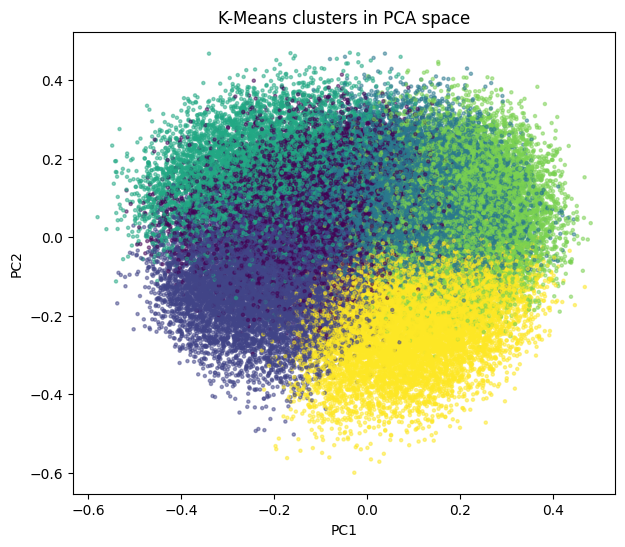

In [55]:
plt.figure(figsize=(7,6))
plt.scatter(
    df_sample['pca_x'],
    df_sample['pca_y'],
    c=df_sample['cluster_kmeans'],
    s=5,
    alpha=0.5,
    cmap='viridis'
)
plt.title("K-Means clusters in PCA space")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

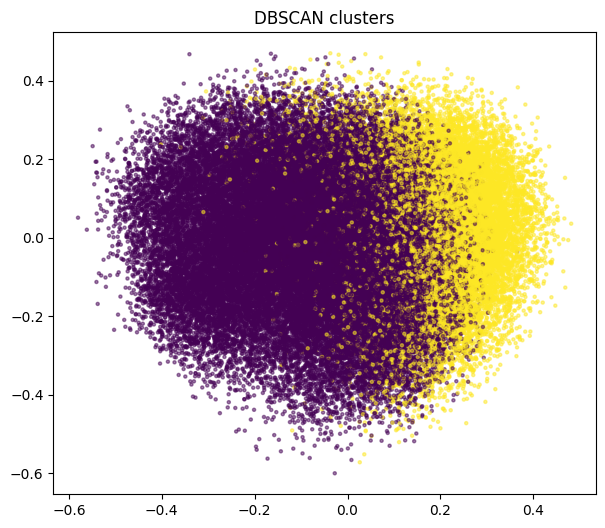

In [56]:
plt.figure(figsize=(7,6))
plt.scatter(
    df_sample['pca_x'],
    df_sample['pca_y'],
    c=df_sample['cluster_dbscan'],
    s=5,
    alpha=0.5,
    cmap='viridis'
)
plt.title("DBSCAN clusters")
plt.show()

We can literally see groups of players who are talking about the same thing in the same emotional tone.

This is what a "player sentiment map" looks like.


In [57]:
print("KMeans clusters + counts")
print(df_sample['cluster_kmeans'].value_counts())

print("\nAgglomerative clusters + counts")
print(df_sample['cluster_agg'].value_counts())

print("\nDBSCAN clusters + counts")
print(df_sample['cluster_dbscan'].value_counts())

KMeans clusters + counts
cluster_kmeans
2    14158
5    11898
1    10253
4     9569
0     7427
3     6663
Name: count, dtype: int64

Agglomerative clusters + counts
cluster_agg
2    22039
0    16355
1     7520
3     6168
4     5612
5     2274
Name: count, dtype: int64

DBSCAN clusters + counts
cluster_dbscan
-1    43844
 0    16124
Name: count, dtype: int64


## 8. Cluster interpretation: what players are actually saying

For each K-Means cluster:
1. Compute top TF-IDF terms used **within that cluster only**.
2. Compute the average `review_score` (1 = recommends, -1 = does not recommend).
3. Sample actual raw reviews.

This gives us:
- What defines the cluster.
- How happy / angry that cluster is.
- Real quotes we can show to product / community / trust & safety.

We'll start with `cluster_kmeans`.


In [ ]:
def describe_cluster(df, cluster_col, cluster_id,
                     text_col='clean_text',
                     raw_col='review_text',
                     topn=15, n_examples=3):
    subset = df[df[cluster_col] == cluster_id]
    print(f"\n====== Cluster {cluster_id} ======")
    print("Size:", subset.shape[0])

    # Get top terms inside this cluster using TF-IDF
    vec = TfidfVectorizer(
        max_features=3000,
        stop_words='english'
    )
    X = vec.fit_transform(subset[text_col])
    mean_tfidf = np.asarray(X.mean(axis=0)).ravel()
    top_idx = mean_tfidf.argsort()[::-1][:topn]
    terms = vec.get_feature_names_out()[top_idx]
    print("Top terms:", ", ".join(terms))

    # Sentiment proxy for business impact
    if 'review_score' in subset.columns:
        avg_score = subset['review_score'].mean()
        print("Avg review_score:", round(avg_score, 3))

    # Pull example raw reviews (not cleaned) to read tone
    examples = subset[raw_col].sample(
        n=min(n_examples, len(subset)),
        random_state=42
    ).tolist()
    print("Examples:")
    for ex in examples:
        print("-", ex[:240].replace("\n"," "), "...")
    print()

In [59]:
for cid in sorted(df_sample['cluster_kmeans'].unique()):
    describe_cluster(df_sample, 'cluster_kmeans', cid)


====== Cluster 0 ======
Size: 7427
Top terms: buy, like, fun, good, worth, money, time, hours, don, free, great, sale, price, bought, got
Avg review_score: 0.311
Examples:
- Unfortunately Tropico 5 is another step in the wrong direction due to lazily implemented game mechanics. I'm glad I waited until this was on sale for $10 with all DLC, but even still it managed to disappoint. It seems they will never make a ...
- I still haven't gotten the secret gay ending so consider this review incomplete. Pretty good but EXPENSIVE, this game needs to be $1.79 cheaper. ...
- Game is awesome. Took me a little while to get in to it, because when you first start Dota seems complicated, confusing, and spontaneous. After a week or so of playing/trying to understand the game I understood it and tried to learn some of ...


====== Cluster 1 ======
Size: 10253
Top terms: like, fun, good, time, best, great, love, don, people, got, life, hours, friends, better, want
Avg review_score: 0.65
Examples:
- Thi

### Named player segments (from K-Means)

Below are the final segments we identified, with their size and sentiment.  
(Cluster IDs come from K-Means; the names are mine.)

- **Cluster 3 — Critical Failure / "Unplayable" Segment (~6.6K reviews, AvgScore ≈ -0.11)**  
  Language: `lag`, `fps`, `crash`, `server`, `cheater`, `anti-cheat`, `unplayable`, `refund`.  
  These players are actively angry. They call the game broken, unfair, or abandoned.  
  → This is the #1 churn risk.

- **Cluster 0 — Price / Value Friction (~7.4K reviews, AvgScore ≈ 0.31)**  
  Language: `buy`, `worth`, `money`, `sale`, `price`, `dlc`, `expensive`, `content`.  
  Theme: "It's only worth it on sale," "too expensive for what you get."  
  → Monetization & perceived greed is a measurable sentiment problem.

- **Cluster 4 — Needs Polish / Quality of Life (~9.6K reviews, AvgScore ≈ 0.50)**  
  Language: `fun but`, `balance`, `bugs`, `content`, `progression`, `pve`, `pvp`.  
  Tone: "The core is good but fix these issues."  
  → These are savable. They *want* to like it more.

- **Cluster 1 — Core Gameplay Experience (~10.2K reviews, AvgScore ≈ 0.65)**  
  Language: `friends`, `hours`, `intense`, `finally beat`, `best`, `love`.  
  Tone: Emotional, high-engagement, satisfying challenge stories.  
  → This is your "fun to play" marketing pillar.

- **Cluster 2 — Story / Immersion / Recommendation (~14.1K reviews, AvgScore ≈ 0.72)**  
  Language: `story`, `character`, `voice acting`, `atmosphere`, `recommend`, `worth your time`.  
  Tone: Proud, reflective, immersive.  
  → This is word-of-mouth fuel.

- **Cluster 5 — Superfans / Evangelists (~11.9K reviews, AvgScore ≈ 0.79)**  
  Language: `best ever`, `incredible`, `masterpiece`, `recommend`, `favorite`, `hours and hours`.  
  Tone: Pure advocacy.  
  → This is what you showcase in marketing and trailers.


In [60]:
for cid in sorted(df_sample['cluster_dbscan'].unique()):
    describe_cluster(df_sample, 'cluster_dbscan', cid) 


====== Cluster -1 ======
Size: 43844
Top terms: like, fun, good, great, time, story, don, best, buy, love, hours, recommend, worth, people, got
Avg review_score: 0.508
Examples:
- A nice relaxation game.  Pay a dollar. Connect. Just walk around, enjoy the sight, feel idle. Relax.  This game is like your old home. Any time you're really exhausted, you can come back here, reclaim the peace of your mind, and leave for n ...
- still my favorite of the civilization games ...
- I thought this was supposed to be a remake of the original. Cause it had a story and this one doesn't. I don't count the store page details as story.    Gameplay is okay. Super hand holdy. With an arrow constantly letting you know which way ...


====== Cluster 0 ======
Size: 16124
Top terms: like, good, story, fun, great, time, gameplay, don, graphics, new, lot, hours, way, best, combat
Avg review_score: 0.641
Examples:
- Nice game with nice visuals and pretty good gameplay for a space shoot em up but has a few prob

## 9. Which segments hurt us the most?

We can rank each cluster by:
- how *big* it is (how many reviews),
- how *angry / happy* it is (average `review_score`).

This tells us:  
Where are the biggest / loudest problems?
Where is the love?
Which themes are "fix this now or we bleed users"?

In [61]:
cluster_summary = (
    df_sample
    .groupby('cluster_kmeans')
    .agg(
        NumReviews = ('review_text', 'count'),
        AvgScore   = ('review_score', 'mean')).sort_values(by='AvgScore'))

cluster_summary

,NumReviews,AvgScore
cluster_kmeans,,
3,6663,-0.108210
0,7427,0.310623
4,9569,0.500888
1,10253,0.650054
2,14158,0.716768
5,11898,0.791394


### Strategic takeaways
- **Cluster 3 (AvgScore ≈ -0.11)** is a catastrophic trust / quality issue. This is not "mild frustration", this is "refund now."
- **Cluster 0 (AvgScore ≈ 0.31)** is all about price fairness and monetization perception. Messaging and packaging can directly impact this.
- On the positive side, Cluster 2 and Cluster 5 (AvgScore ≈ 0.7–0.8) are where players are writing "I recommend this," praising story, immersion, replayability, and emotional experience.

In other words:
- Fix cheating / stability / unplayable performance FIRST (Cluster 3).
- Reposition or justify pricing / DLC value (Cluster 0).
- Market the hell out of story, immersion, emotional moments with friends (Clusters 1, 2, 5).


---

## Appendix

**Tech stack**
- pandas for data manipulation
- spaCy for lemmatization / language cleanup
- scikit-learn for TF-IDF, NMF, K-Means, Agglomerative, PCA, Silhouette
- sentence-transformers (`all-MiniLM-L6-v2`) for semantic embeddings
- matplotlib / seaborn for plots

**Why unsupervised?**
- There is no labeled "churn reason" or "frustration category".
- We let player language self-organize into themes, then we interpret them.
- We mapped those themes to sentiment (`review_score`) to quantify impact.

**Why this matters for a studio / publisher**
- This pipeline is effectively "automated voice of the player at scale".
- You can run it after every major patch / season launch.
- You can track: Are players mad about performance? monetization? fairness?
- You can detect new pain themes early (DBSCAN outliers = new fires).

**Limitations / ethics**
- Review_score is coarse (recommended vs not) → it's a proxy, not a full sentiment model.
- Sample is biased toward people who write long reviews and/or care enough to complain.
- We are mining public user feedback; in production we'd (1) anonymize, (2) monitor for harassment/toxicity references and handle responsibly, (3) comply with platform policies.

**Next steps**
- Trend analysis over time (e.g. did performance rage spike after Patch X?).
- Model per-game segments (which titles are bleeding trust fastest?).
- Surface "trust & safety" risk: toxicity / cheating / harassment, routed to moderation.
- Tie topics to retention / playtime if you have first-party telemetry.
